# The Forecaster

## Libraries and settings

In [32]:
# Libraries
import os
import numpy as np
import pandas as pd
from sklearn import tree
import mysql.connector as sql
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder


# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Show current working directory
print(os.getcwd())

/Users/tobias/Dev/Studium/SEM3/DA/LN


## Import the apartment data

In [46]:
# Connect to Wine Database
db_connection = sql.connect(host='lx26.hoststar.hosting',
                            database="ch309974_DA_winery", user='ch309974_DA_winery_user', password='ch309974_DA_winery_user1!')

# We assume that all values that are 0 or null don't have Ratings. That's why we exclude it.
query = 'SELECT * FROM wine where bewertung > 0'
df_response = pd.read_sql(sql=query, con=db_connection)

# Remove some 'extreme' values
df = df_response.loc[(df_response['preis_chf'] >= 5) &
            (df_response['preis_chf'] <= 500)]

# Reset index
df = df.reset_index(drop=True)

In [47]:
df

,typ,wein_name,land,region,produzent,rebsorte,bewertung,alkohol,inhalt_cl,anzahl_fl,jahrgang,prime_start,prime_end,preis_chf,preis_cl,lat,lon
0,rot,Apothic Inferno Red Blend Wine with a Whiskey ...,USA,None,E. & J. Gallo Winery,None,4.0,16.0,75.0,1,2018,2022,2023,19.95,0.27,39.7837304,-100.445882
1,rot,Apothic Dark California Red Blend,USA,None,None,diverse Sorten,5.0,14.0,75.0,1,2016,2022,2024,12.95,0.17,39.7837304,-100.445882
2,rot,Amarone della Valpolicella DOCG Vigne Alte Zeni,Italien,Venetien,Cantina Zeni,Molinara,5.0,15.5,75.0,1,2019,2024,2028,32.95,0.44,42.6384261,12.674297
3,rot,Amarone della Valpolicella DOCG Vigne Alte Zeni,Italien,Venetien,Cantina Zeni,Molinara,5.0,15.5,75.0,1,2018,2023,2027,32.95,0.44,42.6384261,12.674297
4,rot,Amarone della Valpolicella DOCG Rocca Alata,Italien,Venetien,Cantina di Soave,Corvina,4.0,14.5,75.0,1,2018,2019,2025,21.50,0.29,42.6384261,12.674297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1284,schaumwein,Rosé Selección Raventós Codorníu brut,Spanien,Katalonien,None,Pinot Noir,2.0,14.5,75.0,1,2020,2023,2027,57.00,0.76,39.3260685,-4.8379791
1285,schaumwein,Rosé Prosecco DOC Marca Oro Valdo brut,Italien,None,None,"Pinot Noir, \n Glera",4.5,13.5,75.0,1,2020,2024,2026,25.50,0.34,42.6384261,12.674297
1286,schaumwein,Roger Goulart Cava Reserva Brut,Katalonien,None,None,Macabeo,5.0,14.5,75.0,1,2020,2022,2026,9.95,0.13,41.8523094,1.5745043
1287,schaumwein,Roger Goulart Brut Cava Rosé,Katalonien,None,None,Pinot Noir,3.0,13.0,75.0,1,2021,2023,2025,14.95,0.20,41.8523094,1.5745043


## Regression Tree
See also: https://data36.com/regression-tree-python-scikit-learn

### Create train and test samples for the regression tree (train = 80%, test = 20% of the data)

In [48]:
# Create train and test samples
X_train, X_test, y_train, y_test = train_test_split(df[['bewertung',
                                                        'alkohol',
                                                        'inhalt_cl',
                                                        'jahrgang',
                                                        'prime_start']],
                                                    df['preis_chf'],
                                                    test_size=0.20,
                                                    random_state=42)

# Show X_train
print('X_train:')
print(X_train.head(), '\n')

# Show y_train
print('y_train:')
print(y_train.head())

X_train:
y_train:
634     45.00
673     19.95
823      9.95
1151    24.95
135     16.50
Name: preis_chf, dtype: float64
X_train:
      bewertung  alkohol  inhalt_cl  jahrgang  prime_start
634         5.0     14.0       75.0      2020         2024
673         4.0     13.5       75.0      2017         2022
823         3.0     14.5       37.5      2018         2023
1151        4.5     14.0       75.0      2016         2022
135         4.0     14.5       75.0      2018         2022 

y_train:
634     45.00
673     19.95
823      9.95
1151    24.95
135     16.50
Name: preis_chf, dtype: float64


### Fit the regression tree model

In [49]:
# Create decision tree regressor object
reg = DecisionTreeRegressor(random_state=20, max_depth=5)

# Train decision tree regressor
reg = reg.fit(X_train, y_train)

# Predict the response for test dataset
y_pred = reg.predict(X_test)

### Calculate coefficient of determination (R-squared)

In [50]:
# Calculate coefficient of determination
print('R-squared:', r2_score(y_test, y_pred).round(4))

R-squared: 0.64


### Our Evaluation

This evaluation states that we have 64% correlation. After creating the 2. Variation of Prediciton we realized that this is the closest correlation we're gonna get. So we are gonna move with that. a

### Print text representation of the regression tree

In [51]:
# Text representation of the regression tree
text_representation = tree.export_text(reg, 
                                       feature_names=list(X_train.columns))

# Print text_representation
print(text_representation)

|--- jahrgang <= 2015.50
|   |--- prime_start <= 2023.50
|   |   |--- alkohol <= 14.25
|   |   |   |--- bewertung <= 2.25
|   |   |   |   |--- jahrgang <= 2012.50
|   |   |   |   |   |--- value: [115.00]
|   |   |   |   |--- jahrgang >  2012.50
|   |   |   |   |   |--- value: [34.70]
|   |   |   |--- bewertung >  2.25
|   |   |   |   |--- bewertung <= 4.25
|   |   |   |   |   |--- value: [34.81]
|   |   |   |   |--- bewertung >  4.25
|   |   |   |   |   |--- value: [24.76]
|   |   |--- alkohol >  14.25
|   |   |   |--- bewertung <= 4.75
|   |   |   |   |--- bewertung <= 2.75
|   |   |   |   |   |--- value: [97.50]
|   |   |   |   |--- bewertung >  2.75
|   |   |   |   |   |--- value: [44.41]
|   |   |   |--- bewertung >  4.75
|   |   |   |   |--- jahrgang <= 2012.50
|   |   |   |   |   |--- value: [37.23]
|   |   |   |   |--- jahrgang >  2012.50
|   |   |   |   |   |--- value: [90.21]
|   |--- prime_start >  2023.50
|   |   |--- alkohol <= 13.75
|   |   |   |--- value: [209.00]
|   |  

### Vizualizing the regression tree

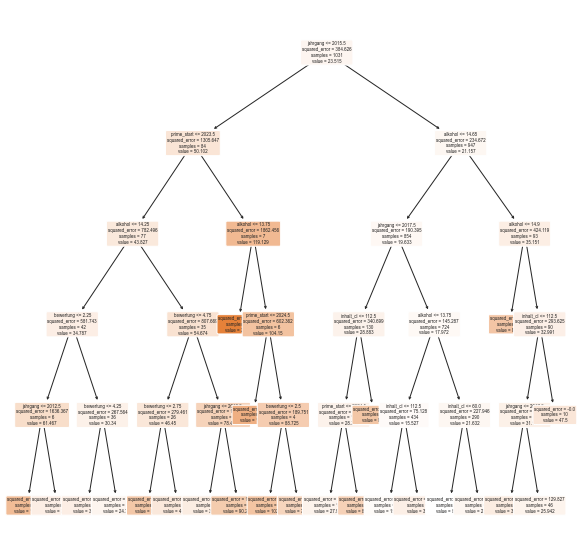

In [52]:
fig = plt.figure(figsize=(10,10))
_ = tree.plot_tree(reg, 
                   feature_names=list(X_train.columns),  
                   class_names=['price'],
                   filled=True,
                   fontsize=4.5,
                   rounded=True)

## Random Forest Regression
For details see: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

### Create train and test samples for the random forest (train = 80%, test = 20% of the data)

In [53]:
# Create train and test samples (the names X2_ and y2_ were used because X_ and y_ were already used above)
X2_train, X2_test, y2_train, y2_test = train_test_split(df[['bewertung',
                                                            'alkohol',
                                                            'inhalt_cl',
                                                            'jahrgang',
                                                            'prime_start']],
                                                        df['preis_chf'],
                                                            test_size=0.20, 
                                                            random_state=42)
# Show X2_train
print('X2_train:')
print(X2_train.head(), '\n')

# Show y2_train
print('y2_train:')
print(y2_train.head())

X2_train:
      bewertung  alkohol  inhalt_cl  jahrgang  prime_start
634         5.0     14.0       75.0      2020         2024
673         4.0     13.5       75.0      2017         2022
823         3.0     14.5       37.5      2018         2023
1151        4.5     14.0       75.0      2016         2022
135         4.0     14.5       75.0      2018         2022 

y2_train:
634     45.00
673     19.95
823      9.95
1151    24.95
135     16.50
Name: preis_chf, dtype: float64


### Fit the Random Forest Regression

In [54]:
X, y = make_regression(n_features=4, n_informative=2,
                       random_state=5, shuffle=False)


reg_rf = RandomForestRegressor(n_estimators=500, 
                               max_depth=10, 
                               random_state=5)
reg_rf.fit(X2_train, y2_train)

# Calculate coefficient of determination (R-squared)
print('R-squared:', reg_rf.score(X2_test, y2_test).round(4))

R-squared: 0.642


### Our Evaluation

This evaluation states that we have 64% correlation. After creating the 2. Variation of Prediciton we realized that this is the closest correlation we're gonna get. So we are gonna move with that. a

R-Squared is negative since the data doesn't correlate

### Show feature importance

Index(['jahrgang', 'alkohol', 'prime_start', 'bewertung', 'inhalt_cl'], dtype='object')
[0.35402634 0.20493439 0.1967476  0.15293846 0.09135322]


<AxesSubplot:ylabel='features'>

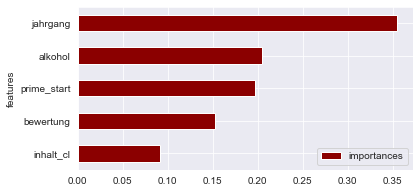

In [55]:
cols = X2_train.columns

# Derive feature importance from random forest
importances = reg_rf.feature_importances_
std         = np.std([tree.feature_importances_ for tree in reg_rf.estimators_], axis=0)
indices     = np.argsort(importances)[::-1]

# Print col-names and importances-values
print( cols[indices] )
print( importances[indices] )

# Barplot with feature importance
df_fi = pd.DataFrame({'features':cols,'importances': importances})
df_fi.sort_values('importances', inplace=True)
df_fi.plot(kind='barh', 
           y='importances', 
           x='features', 
           color='darkred', 
           figsize=(6,3))

Yes the importance changes since area was deleted, other variables are now more important and leading.